{81: 61, 198: 63, 206: 70, 139: 61, 24: 76, 89: 57, 16: 53, 143: 73, 194: 80, 20: 60, 135: 58, 131: 55, 202: 78, 85: 60, 93: 63, 28: 56}
b=1 A=5 N=13
|x>: 1 |b*A^x mod N>: 5 Esperado: 5
|x>: 6 |b*A^x mod N>: 12 Esperado: 12
|x>: 14 |b*A^x mod N>: 12 Esperado: 12
|x>: 11 |b*A^x mod N>: 8 Esperado: 8
|x>: 8 |b*A^x mod N>: 1 Esperado: 1
|x>: 9 |b*A^x mod N>: 5 Esperado: 5
|x>: 0 |b*A^x mod N>: 1 Esperado: 1
|x>: 15 |b*A^x mod N>: 8 Esperado: 8
|x>: 2 |b*A^x mod N>: 12 Esperado: 12
|x>: 4 |b*A^x mod N>: 1 Esperado: 1
|x>: 7 |b*A^x mod N>: 8 Esperado: 8
|x>: 3 |b*A^x mod N>: 8 Esperado: 8
|x>: 10 |b*A^x mod N>: 12 Esperado: 12
|x>: 5 |b*A^x mod N>: 5 Esperado: 5
|x>: 13 |b*A^x mod N>: 5 Esperado: 5
|x>: 12 |b*A^x mod N>: 1 Esperado: 1


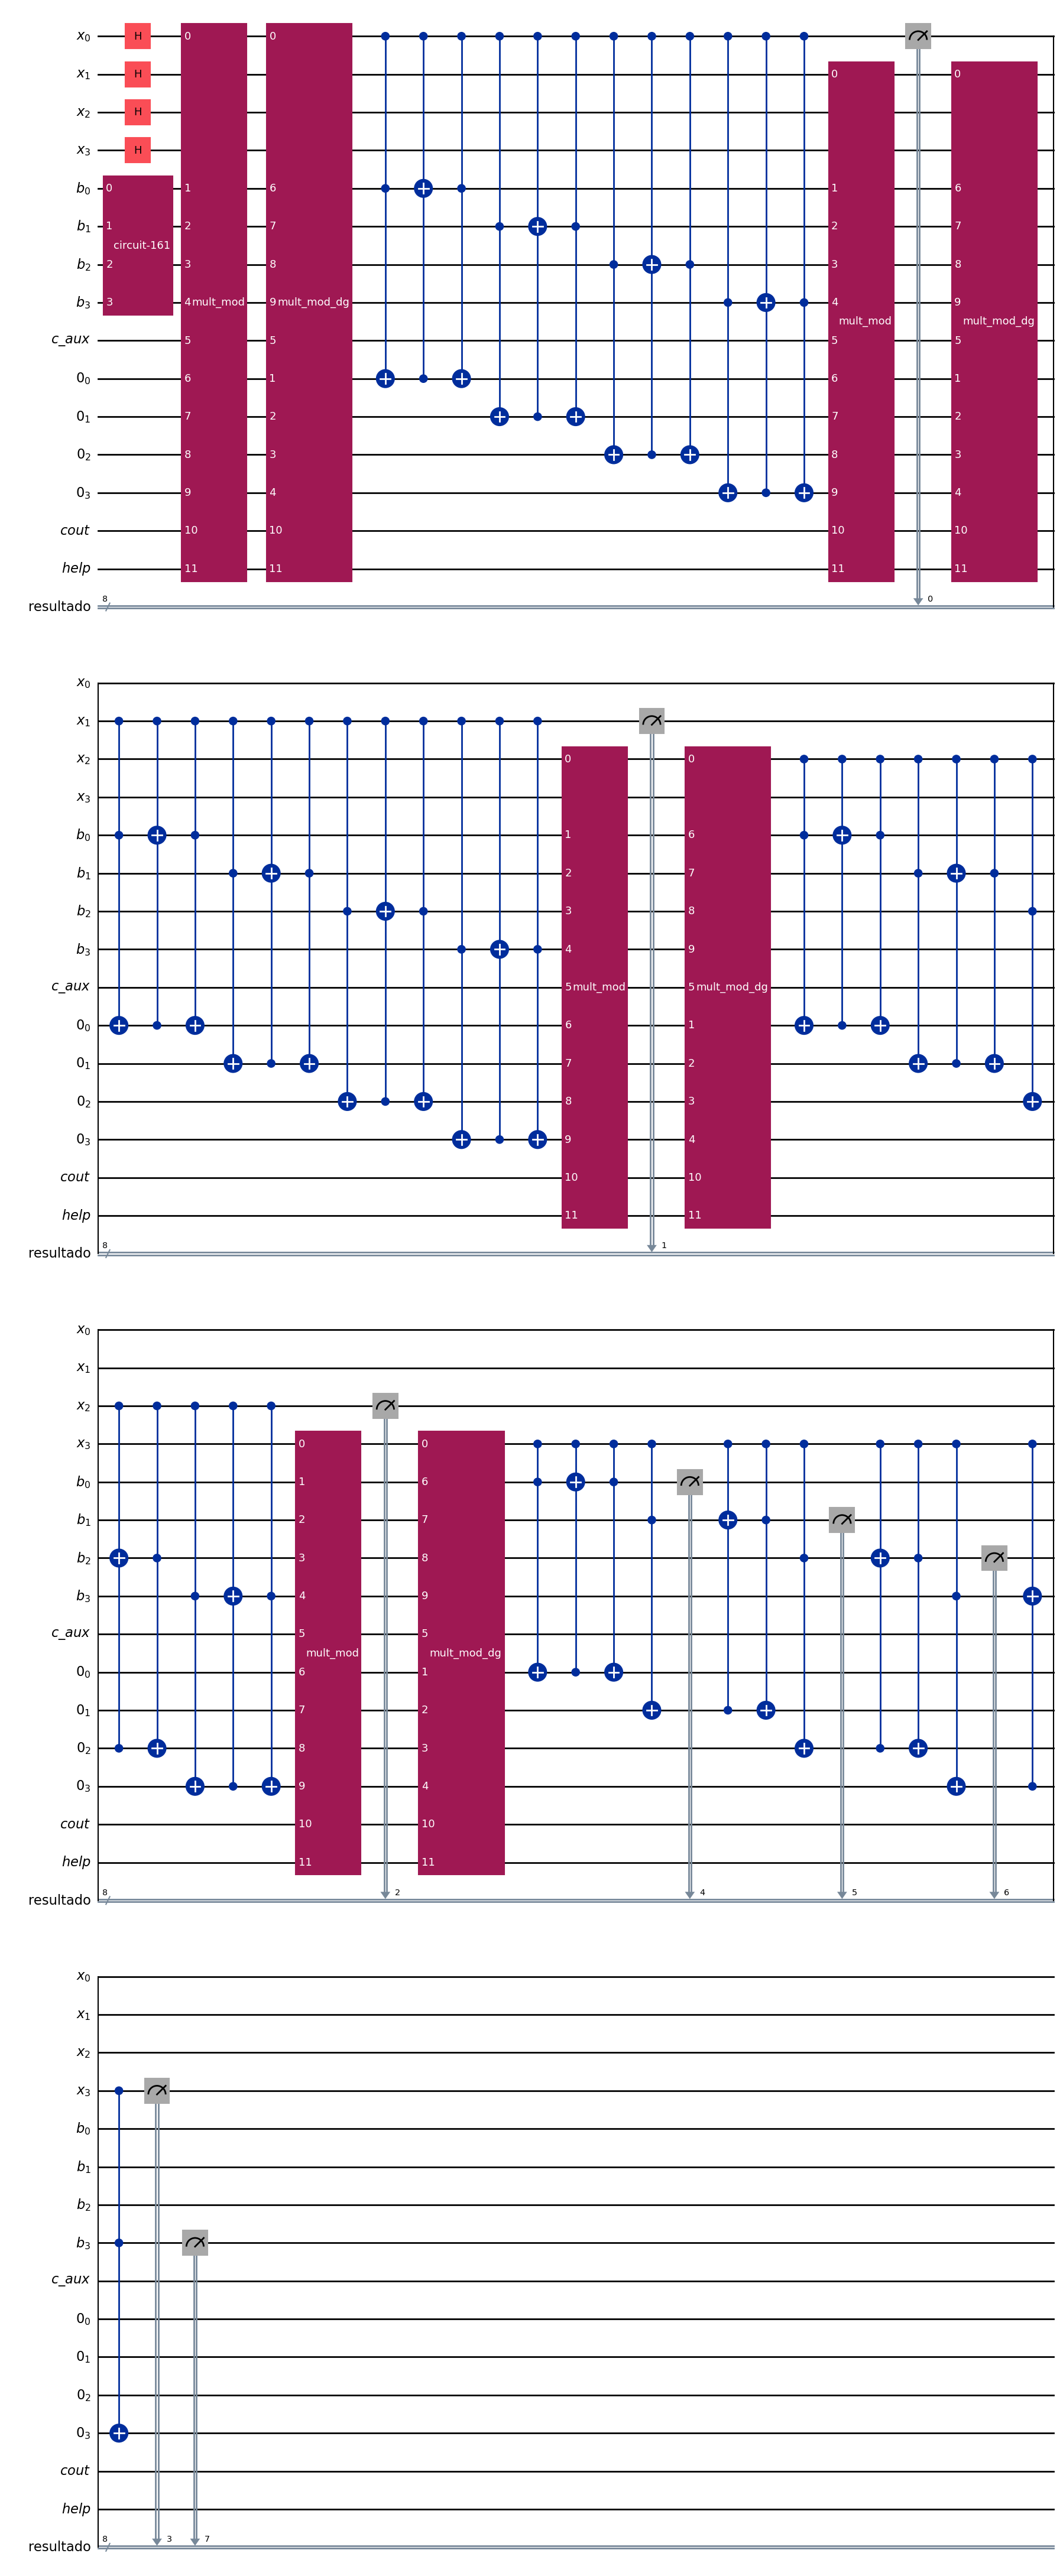

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from ctrl_mult_mod import ctrl_mult_mod
from math import log2


N = 13
n_bits = int(log2(N))+1
A = 200 % N
a_bits = int(log2(A))+1
b = 1
b_bits = int(log2(b))+2
x = 13
x_bits = int(log2(x))+1

reg_x = QuantumRegister(x_bits, "x")
number_x = QuantumCircuit(reg_x)
#number_x.initialize(x)

reg_b = QuantumRegister(n_bits, "b")
number_b = QuantumCircuit(reg_b)
number_b.initialize(b)

reg_c_aux = QuantumRegister(1, "c_aux")

reg_0 = QuantumRegister(n_bits, "0")

reg_cout = QuantumRegister(1, "cout")

reg_help = QuantumRegister(1, "help")

reg_result = ClassicalRegister(x_bits + n_bits, "resultado")


#x_bits + 2*n_bits + 3
circuito = QuantumCircuit(reg_x, reg_b, reg_c_aux, reg_0, reg_cout, reg_help, reg_result)


circuito.h(reg_x)
#circuito.append(number_x, reg_x)
circuito.append(number_b, reg_b)

for i in range(x_bits):
        circuito.append(ctrl_mult_mod(n_bits, (A**(2**i)) % N, N), reg_x[i:i+1] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

        for j in range(N):
            if (A**(2**i) * j) % N == 1:
                a_inv = j
                break

        circuito.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[i:i+1] + reg_0[:] + reg_c_aux[:] + reg_b[:] + reg_cout[:] + reg_help[:])

        for j in range(n_bits):
            circuito.ccx(reg_x[i], reg_b[j], reg_0[j])
            circuito.ccx(reg_x[i], reg_0[j], reg_b[j])
            circuito.ccx(reg_x[i], reg_b[j], reg_0[j])
    #else:
        #circuito.append(ctrl_mult_mod(n_bits, (A**(2**i)) % N, N), reg_x[i:i+1] + reg_0[:] + reg_c_aux[:] + reg_b[:] + reg_cout[:] + reg_help[:])

        #circuito.append(ctrl_mult_mod(n_bits, (A**(2**i)) % N, N).inverse(), reg_x[i:i+1] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

#circuito.append(QFT(x_bits).inverse(), reg_x[:])

circuito.measure(reg_x[:] + reg_b[:], reg_result)
'''
if x_bits % 2 == 0:
    circuito.measure(reg_b[:], reg_result)
else:
    circuito.measure(reg_0[:], reg_result)
'''

from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(circuito, backend=backend1)

from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=1024)
print(job.result()[0].data.resultado.get_int_counts())


counts = job.result()[0].data.resultado.get_int_counts()

print("b=" + str(b), "A=" + str(A), "N=" + str(N))
for i in counts:
    res = f"{i:9b}".strip()
    resB = "0b0" + res[:-x_bits]
    resA = "0b" + res[-x_bits:]
    print("|x>:", eval(resA),"|b*A^x mod N>:",eval(resB), "Esperado:", str(((b*A)**eval(resA)) % N))

Resultado = job.result()[0].data.resultado.get_int_counts()
for i in range(1<<(x_bits + n_bits)):
  if i not in Resultado:
    Resultado[i] = 1

circuito.draw("mpl")

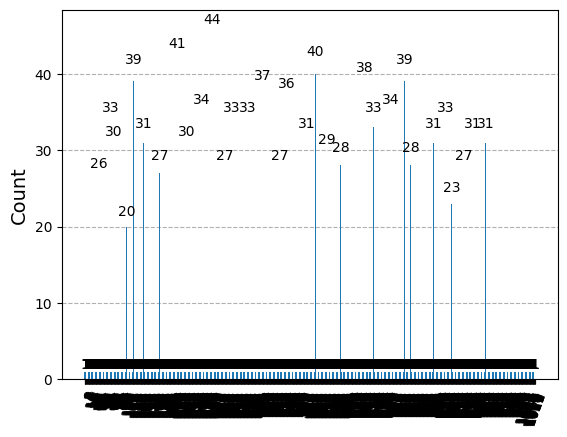

In [2]:
from qiskit.visualization import plot_histogram
plot_histogram(Resultado)